<a href="https://colab.research.google.com/github/kidkmon/Sentiment-Analysis-TripAdvisor/blob/main/Analise_sentimentos_TripAdvisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações

In [1]:
from google.colab import drive # monta ambiente para salvar dados gerados no notebook

import pandas as pd # biblioteca para processamento dos dados
from pandas import json_normalize # realiza a normalização de campos do tipo json no dataframe
import numpy as np # biblioteca de algebra linear

import urllib.request # biblioteca que trabalha com requisições HTTP
import json # biblioteca para processamento de dados do tipo JSON

import seaborn as sns # biblioteca de plotagem de gráficos
import matplotlib.dates as mdates
import matplotlib.pyplot as plt # biblioteca para plotagem de gráficos
%matplotlib inline

from textblob import TextBlob # biblioteca para processamento de dados textuais
from sklearn.metrics import classification_report # biblioteca para calcular as principais métricas de classificação.

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Instalação de pacotes

!python -m textblob.download_corpora
!pip install --upgrade geopandas

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     |████████████████████████████████| 972kB 4.9MB/s 
     |████████████████████████████████| 14.8MB 342kB/s 
     |████████████████████████████████| 6.5MB 49.0MB/s 


In [4]:
# Versão das bibliotecas utilizadas
!python --version
print("Pandas", pd.__version__)
print("Numpy", np.__version__)


import geopandas #biblioteca para trabalhar com dados geospacial

Python 3.6.9
Pandas 1.1.4
Numpy 1.18.5


# Processamento de dados

In [36]:
def load_data(url, encoding="utf-8"):
  dat_file = urllib.request.urlopen(url)

  json_format_file = [json.loads(line) for line in dat_file]

  df = pd.DataFrame(json_format_file)
  
  return df

In [37]:
df = load_data(url="http://tiagodemelo.info/datasets/dataset-v2.dat")
df.head()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,itemReviewed
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ..."
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,"{'name': 'Guacamole Natal', 'address': {'stree..."
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,"{'name': 'Chica Pitanga', 'address': {'streetA..."
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str..."
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'..."


## Limpeza dos dados

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            100000 non-null  object
 1   reviewId         100000 non-null  object
 2   restaurantId     99999 non-null   object
 3   author           99999 non-null   object
 4   reviewBody       99999 non-null   object
 5   language         100000 non-null  object
 6   mobileDevice     100000 non-null  object
 7   userLocation     100000 non-null  object
 8   publicationDate  100000 non-null  object
 9   visitDate        100000 non-null  object
 10  ratingValue      100000 non-null  object
 11  itemReviewed     100000 non-null  object
dtypes: object(12)
memory usage: 9.2+ MB


A partir das informações iniciais pode-se concluir que há dados faltantes na base de dados. Os campos que não possuem dados completos são: **restaurantId**, **author** e **reviewBody**.


## Remoção de colunas no dataset

Algumas colunas não irão exercer impacto durante a análise de dados, logo, optou-se por removê-las. Estas são: **reviewId**, **restaurantId**, **author** e **visitDate**.

In [39]:
columns = ["reviewId", "restaurantId", "author", "visitDate"]

df.drop(columns=columns, inplace=True)

Com a remoção de 3 colunas no conjunto de dados, nota-se que o **reviewBody** possui informações faltantes. Visto que esse campo é um dos mais importantes para a conclusão da análise de dados, optou-se por remover essa informação da base. 

In [40]:
df.dropna(inplace=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            99999 non-null  object
 1   reviewBody       99999 non-null  object
 2   language         99999 non-null  object
 3   mobileDevice     99999 non-null  object
 4   userLocation     99999 non-null  object
 5   publicationDate  99999 non-null  object
 6   ratingValue      99999 non-null  object
 7   itemReviewed     99999 non-null  object
dtypes: object(8)
memory usage: 6.9+ MB


Agora todo o conjunto de dados possui 99.999 dados sobre revisões de restaurantes e 8 colunas.

## Criação de novas colunas para a análise


As informações das colunas **userLocation** e **itemReviewed** podem ser distribuídas em outras, facilitando, assim, a criação de novas visualizações de dados. 

A **userLocation** pode ser dividida em dados sobre a cidade e uma outra referente ao estado em que o usuário fez a revisão. 

In [42]:
## coluna userLocation

df["userLocation"]

0            São Carlos, SP
1                Manaus, AM
2               Goiânia, GO
3               Aracaju, SE
4        Rio de Janeiro, RJ
                ...        
99995      Porto Alegre, RS
99996         Cork, Irlanda
99997         São Paulo, SP
99998      Porto Alegre, RS
99999            Manaus, AM
Name: userLocation, Length: 99999, dtype: object

In [43]:
location = df["userLocation"].str.split(",", n = 1, expand = True) 

df["userCity"] = location[0]
df["userState"] = location[1]

df.drop(columns=["userLocation"], inplace=True)

df.head()

,title,reviewBody,language,mobileDevice,publicationDate,ratingValue,itemReviewed,userCity,userState
0,Jantar,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,26/07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ...",São Carlos,SP
1,Uma boa experiência.,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,16/09/2014,4,"{'name': 'Guacamole Natal', 'address': {'stree...",Manaus,AM
2,Otimo self service,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,04/06/2019,4,"{'name': 'Chica Pitanga', 'address': {'streetA...",Goiânia,GO
3,O sorvete mais tradicional do estado,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,15/03/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str...",Aracaju,SE
4,Melhor hamburger!,O melhor hamburger que já comi! Excelente aten...,pt,False,28/04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'...",Rio de Janeiro,RJ


In [44]:
## coluna itemReviewed

df["itemReviewed"]

0        {'name': 'Imperador dos Camarões', 'address': ...
1        {'name': 'Guacamole Natal', 'address': {'stree...
2        {'name': 'Chica Pitanga', 'address': {'streetA...
3        {'name': 'Sorvetes Vi Sabor', 'address': {'str...
4        {'name': 'Z Deli Sandwich Shop', 'address': {'...
                               ...                        
99995    {'name': 'Boteco Maestro', 'address': {'street...
99996    {'name': 'Casa do Marquês', 'address': {'stree...
99997    {'name': 'Rio Scenarium', 'address': {'streetA...
99998    {'name': 'Celeiro', 'address': {'streetAddress...
99999    {'name': 'Coco Bambu Manaus', 'address': {'str...
Name: itemReviewed, Length: 99999, dtype: object

A **itemReviewed** possui muitas informações interessantes e que podem contribuir para uma análise mais completa. Esses dados são: 

*   **name**: Nome do restaurante;
*   **address**: Endereço do restaurante;
*   **website**: Endereço do site do restaurante;
*   **email**: E-mail do restaurante;
*   **phoneNumber**: Telefone do restaurante;
*   **averageRating**: Média de avaliação do restaurante;


Os campos website, email e phoneNumber serão utilizados nessa análise para saber se os estabelecimentos que possuem essas informações possuem maior probabilidade de terem pontuações maiores.

In [45]:
item_reviewed = json_normalize(df["itemReviewed"])
item_reviewed.head()

,name,website,email,phoneNumber,averageRating,address.streetAddress,address.addressLocality,address.addressRegion,address.postalCode,address.country
0,Imperador dos Camarões,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil
1,Guacamole Natal,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil
2,Chica Pitanga,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil
3,Sorvetes Vi Sabor,None,None,None,4.0,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil
4,Z Deli Sandwich Shop,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil


Processamento dos dados contidos no campo **itemReviewed**

In [46]:
df["hasEmail"] = item_reviewed["email"].apply(lambda value: 
                                                      "True" if value != "None" else "False")

df["hasEmail"].fillna("no")

0         True
1         True
2         True
3        False
4        False
         ...  
99995     True
99996    False
99997     True
99998     True
99999       no
Name: hasEmail, Length: 99999, dtype: object

In [47]:
df["hasPhone"] = item_reviewed["phoneNumber"].apply(lambda value: 
                                                      "True" if value != "None" else "False")

df["hasPhone"].fillna("no")

0         True
1         True
2         True
3        False
4         True
         ...  
99995     True
99996     True
99997     True
99998     True
99999       no
Name: hasPhone, Length: 99999, dtype: object

## Geração de dados Geolocalizados

Nesta etapa do processamento, foi realizada a manipulação dos dados para a geração de valores de **longitude** e **latitude**. Utilizou-se os campos "address.streetAddress", "address.addressLocality", "address.addressRegion", "address.postalCode" para essa ação. 

In [48]:
columns = ["name", "address.streetAddress", "address.addressLocality", "address.addressRegion", "address.postalCode"]

address_group = item_reviewed.groupby(columns).size().reset_index(name="count")
address_group

,name,address.streetAddress,address.addressLocality,address.addressRegion,address.postalCode,count
0,&EAT Restaurante,Rua Clodomiro Amazonas 77,São Paulo,Estado de São Paulo,04537-010,2
1,''Pino Spazio'',Rua Galeno de Revoredo 22 Itaim Bibi,São Paulo,Estado de São Paulo,04531-030,1
2,+ Sabor,Rua Artur Bernardes 1159 Lourival Parente,Teresina,Piauí,64022-108,1
3,00,Avenida Padre Leonel Franca 240 Gávea,Rio de Janeiro,Estado do Rio de Janeiro,22451-000,3
4,011 Gastronomia,Rua Artur de Azevedo 613,São Paulo,Estado de São Paulo,05404-011,12
...,...,...,...,...,...,...
14976,Ópera Arte,Rua João Gava 920 Subsolo da Ópera de Arame,Curitiba,Paraná,82130-010,7
14977,Ô Bar,Avenida Praia de Ponta Negra 9184 Curva do Vento,,Rio Grande do Norte,59092-100,1
14978,Ô Restaurante,Rua Harmonia 321 Vila Madalena,São Paulo,Estado de São Paulo,05435-000,2
14979,Ô Xiss,Rua Padre Chagas 306,Porto Alegre,Rio Grande do Sul,90570-080,5


Foi executado o script [**geopandas_dataset.py**](https://github.com/kidkmon/Sentiment-Analysis-TripAdvisor/blob/main/geopandas_dataset.py) que utilizou a API do Google Maps para armazenar as coordenadas e endereço correto dos 14.981 restaurantes registrados na base de dados.

Estas informações foram armazenadas em um arquivo address.txt.

In [49]:
import geopandas

df_geo = pd.read_csv("data/address.txt", names=["city", "state", "latitude", "longitude"])
df_geo.head()

FileNotFoundError: ignored

Adicionando colunas criadas a partir da API do Google Maps

In [50]:

address_group["city"] = df_geo["city"]
address_group["state"] = df_geo["state"]
address_group["latitude"] = df_geo["latitude"]
address_group["longitude"] = df_geo["longitude"]

NameError: ignored

Removendo colunas que não serão utilizadas

In [ ]:
columns = ["address.streetAddress", "address.addressLocality", "address.addressRegion", "address.postalCode"]
address_group.drop(columns=columns, inplace=True)

address_group.head()

##Geração de dados para Análise Temporal

Gerando campos de ano, mês e dia a partir do campo publicationDate

In [51]:
df["publication_year"] = [x[-4:] for x in df['publicationDate']]
df["publication_month"] = [x[3:5] for x in df['publicationDate']]
df["publication_day"] = [x[:2] for x in df['publicationDate']]


## Conjunto de dados após o processamento



In [52]:
df.head()

,title,reviewBody,language,mobileDevice,publicationDate,ratingValue,itemReviewed,userCity,userState,hasEmail,hasPhone,publication_year,publication_month,publication_day
0,Jantar,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,26/07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ...",São Carlos,SP,True,True,2019,07,26
1,Uma boa experiência.,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,16/09/2014,4,"{'name': 'Guacamole Natal', 'address': {'stree...",Manaus,AM,True,True,2014,09,16
2,Otimo self service,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,04/06/2019,4,"{'name': 'Chica Pitanga', 'address': {'streetA...",Goiânia,GO,True,True,2019,06,04
3,O sorvete mais tradicional do estado,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,15/03/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str...",Aracaju,SE,False,False,2016,03,15
4,Melhor hamburger!,O melhor hamburger que já comi! Excelente aten...,pt,False,28/04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'...",Rio de Janeiro,RJ,False,True,2015,04,28


# Visão Geral dos Dados

**Análise de Distribuição das Notas de Avaliações**

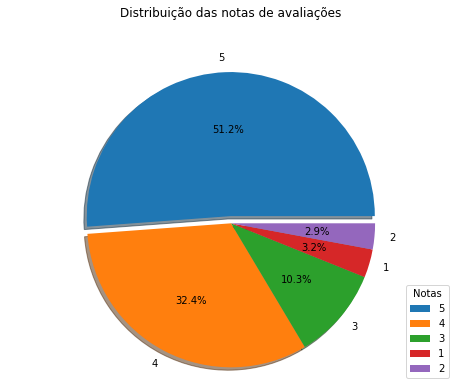

In [ ]:
labels = df['ratingValue'].unique()
rating_percent = df['ratingValue'].value_counts(normalize=True) * 100
explode = (0.05, 0, 0, 0, 0)

fig, ax = plt.subplots(figsize=(8,6))
ax.pie(rating_percent, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
ax.axis('equal')

plt.title('Distribuição das notas de avaliações', pad=40)
ax.legend(labels, loc='lower right', title='Notas')

plt.show()

A avaliação com nota 5 possui a maior frequência dentro do conjunto de dados, enquanto a com nota 2 são as menos frequentes. Dado o gráfico, é possível afirmar que os dados estão desbalanceados pois 51.2% deste conjunto de dados pertencem à avaliação com nota 5, enquanto as outras quatros notas juntas representam o restante dos dados.





**Análise de Distribuição das Avaliações por Diferentes Dispositivos**

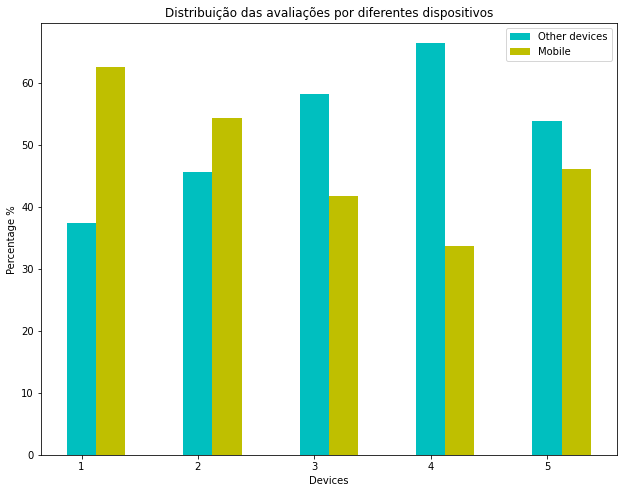

In [ ]:
def get_rating_value_devices():
  devices = []
  for i in range (1,6):
    devices.append(df[df['ratingValue'] == str(i)]['mobileDevice'].value_counts(normalize=True, sort=False) * 100)
  return devices

devices = get_rating_value_devices() 

fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])

X = np.arange(1,6)
ax.bar(X, [device[0] for device in devices], color='c', width = 0.25)
ax.bar(X+0.25, [device[1] for device in devices], color='y', width = 0.25)

plt.xlabel('Devices')
plt.ylabel('Percentage %')
plt.title('Distribuição das avaliações por diferentes dispositivos')
plt.legend(['Other devices', 'Mobile'])

plt.show()

Através do gráfico de barras acima, percebe-se que existe uma diferença de frequência entre dispositivos em relação as notas das avaliações. As notas de avaliações **1** e **2**, possuem as menores frequências de críticas realizadas em outros dispositivos e as maiores frequências realizadas em mobile, pode-se concluir que pessoas insatisfeitas com o restaurante, em sua maioria, possuem o interesse de realizar a crítica o quanto antes, dado isso a plataforma mais acessível seria a mobile.

**Análise Temporal de Interação**

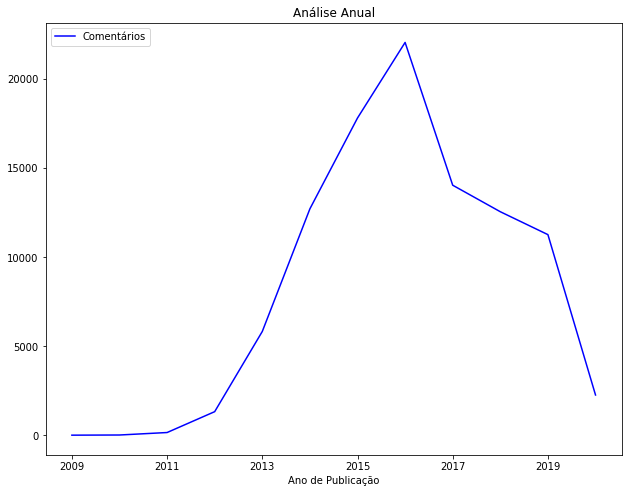

In [138]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
df.groupby('publication_year')['reviewBody'].count().plot(kind='line', label ='Comentários' , color = 'b', ax=ax)
plt.xlabel('Ano de Publicação')
plt.legend(loc = 'upper left')
plt.title('Análise Anual')
plt.show()

O resultado desta análise mostra que o dataset contém amostras de dados do ano de 2009 à 2020, onde o maior número de amostras se concentra em 2016, havendo um crescimento exponancial da iteração de clientes a partir da metade de 2012, e que os dados de 2009 à 2011 são nulos.

**Análise de Interação por Localização**

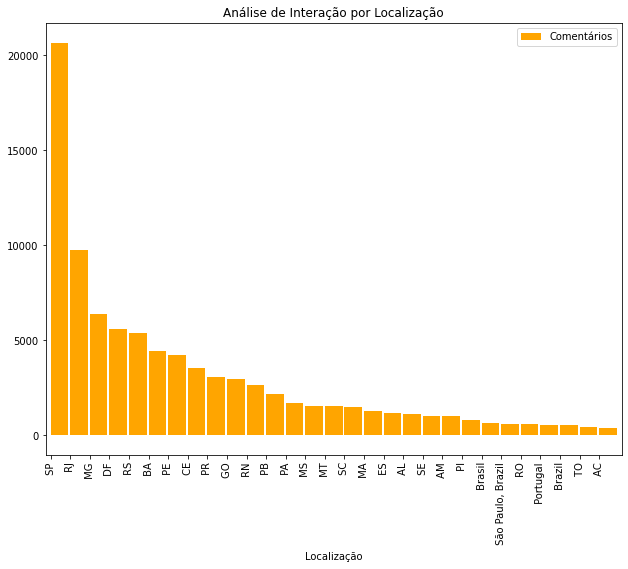

In [136]:
#Gerando dados para análise - groupby
res = df[['userState','reviewBody']].groupby('userState').count()
a = res.sort_values(['reviewBody'], ascending=False)
a.rename({"reviewBody": "Comentários"}, axis=1, inplace=True)

#Construção do Gráfico
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
a[0:29].plot(kind='bar', color ='orange', orientation='horizontal', align='edge',width = 0.9, ax=ax)
plt.xlabel('Localização')
plt.legend(loc = 'upper right')
plt.title('Análise de Interação por Localização')
plt.show()


Através da análise dessa plotagem é visível que os brasileiros tem maior representatividade na interação, evidenciando que a maior parte dos comentários são nacionais, e poucos são estrangeiros. 
Dos 30 estados/países com maior representatividade, os estados nacionais aparecem com um índice de 96,6% e os estrangeiros com 3,3%.



**Média de Sentenças e Palavras por Comentários**

In [ ]:
def mean_sentences_words():
  
  df['reviewBody_TB'] = [TextBlob(comment) for comment in df['reviewBody']]

  mean_sentences = np.mean([len(comment.sentences) for comment in df['reviewBody_TB']])
  mean_words = np.mean([len(comment.word_counts) for comment in df['reviewBody_TB']])

  return [mean_sentences, mean_words]

In [ ]:
mean_reviews = mean_sentences_words()

print("Média de sentenças por comentários: {:.2f}.\n" \
      "Média de palavras por comentários: {:.2f}.".format(mean_reviews[0],
                                                     mean_reviews[1]))

Média de sentenças por comentários: 3.63.
Média de palavras por comentários: 34.67.


#Etapa II

***Análise do resultado do cálculo de subjetividade e polaridade das 200 sentenças utilizando o pacote TextBlob para tradução***

## Selecionar 200 senteças aleatórias da base de dados

In [ ]:
def generate_random_sentences_list():
  rand_sentences = []
  rand_index = np.random.randint(0, df['reviewBody_TB'].size)
  i = 0

  while i < 200:
    sentences = df['reviewBody_TB'][rand_index].sentences

    for sentence in sentences:
      rand_sentences.append(str(sentence))
    
    rand_index = np.random.randint(0, df['reviewBody_TB'].size)
    i += len(sentences)

  return rand_sentences

In [ ]:
rand_sentences = generate_random_sentences_list()

df_sentences = pd.DataFrame({'Sentences': rand_sentences,
                             'Type': [None] * len(rand_sentences),
                             'Polarity': [None] * len(rand_sentences)})

file_path = 'drive/MyDrive/random_sentences.csv'
df_sentences.to_csv(file_path, index=False)

## Análise de sentimentos das sentenças aleatórias

In [ ]:
df_random_sentences = pd.read_csv(file_path)
df_random_sentences.head()

,Sentences,Type,Polarity
0,Uma ótima opção para quem leva uma vida saudáv...,1,1
1,Simplesmente amo!,1,1
2,Sempre peço o de carne com os diversos itens q...,0,0
3,Os sucos também são maravilhosos e adoçados co...,1,1
4,O pedido sai em menos de 5 minutos e o preço é...,1,0


### Tradução das sentenças para inglês

In [ ]:
df_random_sentences['sentences_TB'] = [TextBlob(comment).translate(to='us') for comment in df_random_sentences['Sentences']]

### Cálculo da polaridade

In [ ]:
df_random_sentences['polarity_TB'] = [sentence.sentiment.polarity for sentence in df_random_sentences['sentences_TB']]

### Normalização dos valores da coluna do cálculo da polaridade

In [ ]:
positive_min = 0.5
negative_min = -0.15

df_random_sentences['polarity_TB_normalized'] = [1 if sentence > positive_min
                                                 else -1 if sentence < negative_min
                                                 else 0 
                                                 for sentence in df_random_sentences['polarity_TB']]

### Métricas de desempenho

In [ ]:
target_names = ['Negativa', 'Neutra', 'Positiva']

print(classification_report(df_random_sentences['Polarity'], 
                      df_random_sentences['polarity_TB_normalized'],
                      target_names=target_names))

              precision    recall  f1-score   support

    Negativa       0.79      0.42      0.55        26
      Neutra       0.41      0.89      0.56        53
    Positiva       0.90      0.52      0.66       120

    accuracy                           0.60       199
   macro avg       0.70      0.61      0.59       199
weighted avg       0.75      0.60      0.62       199



#Visão Temporal

****

#Visão Geográfica

In [ ]:
import geopandas

gdf = geopandas.GeoDataFrame(
    address_group, geometry=geopandas.points_from_xy(address_group.longitude, address_group.latitude))

gdf.head()

,name,count,city,state,latitude,longitude,geometry
0,&EAT Restaurante,2,São Paulo,São Paulo,-23.584914,-46.679795,POINT (-46.67979 -23.58491)
1,''Pino Spazio'',1,São Paulo,São Paulo,-23.580586,-46.677558,POINT (-46.67756 -23.58059)
2,+ Sabor,1,Teresina,Piauí,-5.133390,-42.794155,POINT (-42.79416 -5.13339)
3,00,3,Gávea,Rio de Janeiro,-22.978278,-43.230314,POINT (-43.23031 -22.97828)
4,011 Gastronomia,12,NaN,NaN,NaN,NaN,POINT (nan nan)


In [ ]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

In [ ]:
geoplot.polyplot(world, figsize=(8, 4))


NameError: ignored

In [ ]:
pip install basemap

ERROR: Could not find a version that satisfies the requirement basemap (from versions: none)
ERROR: No matching distribution found for basemap
